In [49]:
from google.colab import drive
drive.mount('/gdrive')
%cd '/gdrive/My Drive/Colab Notebooks/'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Colab Notebooks


In [0]:
import os
import numpy as np
import matplotlib.image as mpimg
import pandas as pd
import csv
from PIL import Image
from numpy import linalg as LA
import math
from numpy import genfromtxt
import matplotlib.pyplot as plt

In [51]:
# Open csv file for cov matrix, sum of rgb values, and their means calculated externally
n_barrel_rgb = genfromtxt('data/non_barrel_data.csv', delimiter=',')
print(n_barrel_rgb)
cov_nbar = n_barrel_rgb[0:3]
sum_nbar = n_barrel_rgb[3]
mean_nbar = n_barrel_rgb[4]
num_nbar_pix = n_barrel_rgb[5][0] # total number of not barrel pixels across all images
num_nbar_pix = int(num_nbar_pix)

print(cov_nbar)
print(sum_nbar)
print(mean_nbar)
print(num_nbar_pix)

[[4.56034098e+03 4.15515694e+03 3.84851263e+03]
 [4.15515694e+03 4.33558154e+03 4.05604521e+03]
 [3.84851263e+03 4.05604521e+03 4.01734476e+03]
 [6.58759661e+08 6.29953966e+08 5.82523836e+08]
 [1.22200429e+02 1.16856950e+02 1.08058624e+02]
 [5.39081300e+06 0.00000000e+00 0.00000000e+00]]
[[4560.34098169 4155.15694364 3848.51263196]
 [4155.15694364 4335.58154241 4056.04520827]
 [3848.51263196 4056.04520827 4017.34476096]]
[6.58759661e+08 6.29953966e+08 5.82523836e+08]
[122.20042895 116.85695015 108.05862418]
5390813


In [0]:
barrel_rgb = genfromtxt('data/hw1_class_Red_Barrel.csv', delimiter=',')

In [44]:
# barrel_rgb = barrel_rgb[1:]
bar_len = np.shape(barrel_rgb)
bar_len = bar_len[0]
print(np.shape(barrel_rgb))
print(bar_len)

(736522, 3)
736522


In [45]:
# Calculate the total sum of rgb values and their means for the barrel pixels
sum_rgb_bar = np.sum(barrel_rgb, axis=0) # get sum of all barrel pixels across all images
mean_rgb_bar = sum_rgb_bar / bar_len # get mean of all barrel pixels across all images
print(sum_rgb_bar)
print(mean_rgb_bar)

[1.2368774e+08 3.3539600e+07 3.9367140e+07]
[167.93488857  45.5378115   53.45005309]


In [46]:
# Calculate the covariance for the 
b = []
for i in range(0, bar_len):
    b.append(mean_rgb_bar)
b = np.vstack(b)
a = barrel_rgb - b
aT = np.transpose(a)

cov = np.matmul(aT, a)
cov = cov / bar_len

print(cov)

[[3399.66130749 1240.34012194 1388.7349037 ]
 [1240.34012194  889.98422517  892.02913215]
 [1388.7349037   892.02913215  957.53029659]]


In [0]:
# Get all of the variables needed for Bayes calculations
inv_cov_bar = LA.inv(cov)
inv_cov_nbar = LA.inv(cov_nbar)

norm_cov_bar = LA.norm(cov)
norm_cov_nbar = LA.norm(cov_nbar)

sqrt_norm_cov_bar = np.sqrt(norm_cov_bar)
sqrt_norm_cov_nbar = np.sqrt(norm_cov_nbar)

bar_cont = 1/(2*math.pi*sqrt_norm_cov_bar)
nbar_const = 1/(2*math.pi*sqrt_norm_cov_nbar)

px = 1/(900 * 1200)

(900, 1200, 3)


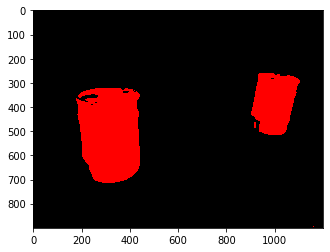

In [52]:
im = Image.open("train/2_3.1.png")
img = np.array(im)
print(np.shape(img))
for i in range (0, 900):
    for j in range (0, 1200):
        pix = img[i, j, :]
        pix_rgb = np.matrix([pix[0], pix[1], pix[2]])

        x_mu = np.array(pix_rgb - mean_rgb_bar)
        x_muT = np.transpose(x_mu)
        calc = np.matmul(x_mu, inv_cov_bar)
        calc = -0.5 * np.matmul(calc, x_muT)
        gaus_bar = bar_cont * math.exp(calc)

        x_mu = np.array(pix_rgb - mean_nbar)
        x_muT = np.transpose(x_mu)
        calc = np.matmul(x_mu, inv_cov_nbar)
        calc = -0.5 * np.matmul(calc, x_muT)
        gaus_nbar = nbar_const * math.exp(calc)

        Pyx = (bar_len * gaus_bar) / px
        Pnyx = (num_nbar_pix * gaus_nbar) / px

        PB = Pyx / (Pyx + Pnyx)
        PnB = Pnyx / (Pyx + Pnyx)

        if (Pyx > Pnyx):
            # img[i, j, :] = [np.round(255 * PB), 0, 0]
            img[i, j, :] = [255, 0, 0]
        else:
            img[i, j, :] = [0, 0, 0]
disp = Image.fromarray(img, 'RGB')
disp.save('my.png')
plt.imshow(img)
plt.show()

In [0]:
for file in sorted(os.listdir('train/')):
    # Iterate through all the image files in folder and get their names
    l = len(file)
    name = file[0:(l-4)]
    print(name)
    im = Image.open("train/" + name + ".png")
    img = np.array(im)

    print(np.shape(img))
    for i in range (0, 900):
        for j in range (0, 1200):
            pix = img[i, j, :]
            pix_rgb = np.matrix([pix[0], pix[1], pix[2]])

            s1 = np.array(pix_rgb - mean_rgb_bar)
            s2 = np.transpose(s1)
            s3 = np.matmul(s1, inv_cov_bar)
            s4 = np.matmul(s3, s2)
            s5 = math.exp(-0.5 * s4)
            gaus_bar = bar_cont * s5

            s1 = np.array(pix_rgb - mean_nbar)
            s2 = np.transpose(s1)
            s3 = np.matmul(s1, inv_cov_nbar)
            s4 = np.matmul(s3, s2)
            s5 = math.exp(-0.5 * s4)
            gaus_nbar = nbar_const * s5

            Pyx = (bar_len * gaus_bar) / px
            Pnyx = (num_nbar_pix * gaus_nbar) / px

            if (Pyx > Pnyx):
                img[i, j, :] = [255, 0, 0]
            else:
                img[i, j, :] = [0, 0, 0]
    import matplotlib.pyplot as plt
    disp = Image.fromarray(img, 'RGB')
    disp.save("classified_img/" + name + ".png")
    plt.imshow(img)
    plt.show()

In [0]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from skimage.draw import ellipse
from skimage.measure import label, regionprops, regionprops_table
from skimage.transform import rotate

name = '4.8' # easy
name = '2_3.1'
name = '10.4'
name = '4.6'
name = '2.6'
name = '2.8'
name = '14'
name = '3.10'
name = '3.2'
name = '4.3'
name = '4.5'
name = '5.4'
name = '5.9'
name = '5.11'
name = '6.3'
name = '8.3'

im = Image.open("classified_imgs/" + name + ".png")
img = np.array(im)

ind = np.zeros((900, 1200))

for i in range(0, 900):
    for j in range(0, 1200):
        if img[i][j][0] == 255:
            ind[i][j] = 1


label_img = label(ind)
regions = regionprops(label_img)

fig, ax = plt.subplots()
ax.imshow(img, cmap=plt.cm.gray)

print(regions[0].orientation)
print(regions[0].major_axis_length)
print(regions[0].minor_axis_length)

print(regions[1].orientation)
print(regions[1].major_axis_length)
print(regions[1].minor_axis_length)

print(regions)

ind = 0
for i in range(0, len(regions)):
    major = regions[ind].major_axis_length
    minor = regions[ind].minor_axis_length
    if regions[ind].bbox_area < 1250 or minor < 5 or (regions[ind].filled_area / regions[ind].bbox_area) < 0.5:
    # if regions[ind].bbox_area < 1250:
        del regions[ind]
    else:
        if major/minor < 1 or major/minor > 3:
            del regions[ind]
        else:
            ind = ind + 1
        # ind = ind + 1

size_list = []
for props in regions:
    size_list.append(props.bbox_area)

ind = 0
max_area = max(size_list)
for i in range(0, len(regions)):
    area = regions[ind].bbox_area
    area_rat = area / max_area
    if area_rat < 0.3:
        del regions[ind]
    else:
        ind = ind + 1

for props in regions:
    y0, x0 = props.centroid
    orientation = props.orientation
    x1 = x0 + math.cos(orientation) * 0.5 * props.minor_axis_length
    y1 = y0 - math.sin(orientation) * 0.5 * props.minor_axis_length
    x2 = x0 - math.sin(orientation) * 0.5 * props.major_axis_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.major_axis_length

    ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
    ax.plot(x0, y0, '.g', markersize=15)

    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, '-b', linewidth=2.5)

    print(props.bbox_area)
    print(props.major_axis_length / props.minor_axis_length)
    print(props.filled_area / props.bbox_area)
    print(props.filled_area / props.area)

ax.axis((0, 1200, 900, 0))
plt.show()